In [2]:
"""Try aperture photometry without calibration?"""
import os
import time
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from astropy.io import fits

from astro import astroutils
from astro import mphot
from astro import mimage
from utils import mutils
from utils import mlogging

from util.data import pload, psave, doublesort

log = mlogging.getLogger( name='calibrate', console=True, filename='ccalibration_log.txt')

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
"""Calibration with bdf and astrometry"""
from ccalibration import calibrate_night, calibrate_year
# scopes = [13, 61]                    
# years = [2017, 2018, 2019, 2020, 2021, 2022]

# for scope in scopes:
#     for year in years:
nights = sorted(glob('/users/canis/dev/holmberg/data/tek2k/2021/???'))

for night in nights:
    log.info(night)
    calibrate_night(path=night, astrometry=True, 
        anetcfg='/usr/local/Cellar/astrometry-net/0.91/etc/astrometry.cfg', format='fits', 
        verbose=False, overwrite=False)
# calibrate_night(path='/Users/canis/dev/holmberg/data/test', astrometry=True, 
#     anetcfg='/usr/local/Cellar/astrometry-net/0.91/etc/astrometry.cfg', format='fits', 
#     verbose=False, overwrite=True)

In [ ]:
"""Remove calibrated files where astrometry failed. Hopefully should remove all of the bad files."""
from ccalibration import remove_bad_astrometry
nights = sorted(glob('/users/canis/dev/holmberg/data/tek2k/2021/???/calibrated'))
for night in nights:
    log.info(night)
    remove_bad_astrometry(path=night)

In [ ]:
"""Seeing calculation"""
from cseeing import calc_seeing_image, calc_seeing_night
files = sorted(glob('/users/canis/dev/holmberg/data/tek2k/2021/???/calibrated/*.a.*'))
seeings = []

pixscal = .3252
dr=3.8
bw=7
sa=15
saturation=28000

target= ('08 19 28.99', '70 42 19.4') # SIMBAD values is correct
comps = [     
            ('08 19 35.27861', '70 42 46.68284'), # A=1774 SNR=592   stdev = 0.2 (previously #1)  
            ('08 19 42.614',   '70 40 23.9842'),    # A=4800 SNR=1078 stdev = 0.05 (previously #5)
            ('08 19 57.87424', '70 42 53.07892'),   # A=2295 SNR=775 stdev = 0.03 (previously #6)
            ('08 19 33.91390', '70 44 27.99391'),   # A=3500 SNR=904      
            ('08 19 15.57437', '70 44 42.37452'),   # A=2014 SNR=637.7
        ]

cntrds = mphot.aperphot(files, startcoords=target,
                                    compcoords=comps, ncompmax=5, snrmin=100,
                                    diskradius=dr, bufferwidth=bw, skyannulus=sa,
                                    Nthresh=2.4, autoradius='fixed', emax=0.5,
                                    saturation=saturation,
                                    nhist=1, quick='noctrd', maxcpus=None, verbose=False)
seeings = [((cntrds[i][8][1:].data) * pixscal) for i in len(cntrds)]

print(seeings[-1])
seeings = np.array(seeings)

In [ ]:
"""Save results"""
times = []
for fn in files:
    with fits.open(fn) as hdul:
        times.append(np.datetime64(hdul[0].header['date-avg']))
seeings_dict = {'files': files, 'seeings': seeings, 'times': times}
psave(seeings_dict, 'seeings.p')

0
1
2
3
4


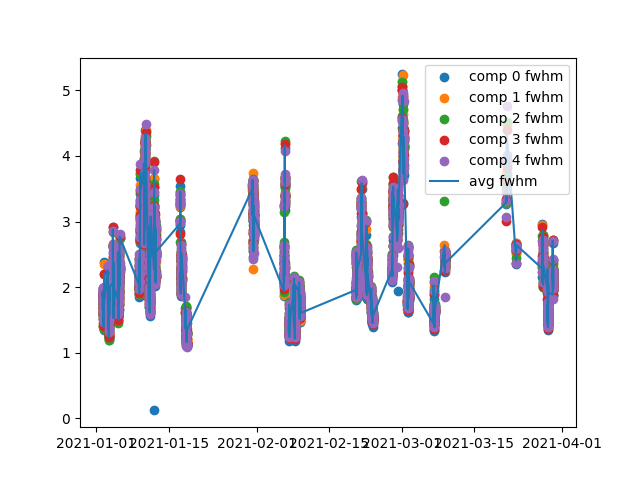

In [6]:
"""Display seeing over time"""
seeings_dict = pload('seeings.p')
files = seeings_dict['files']
seeings = np.array(seeings_dict['seeings'])
times = seeings_dict['times']
# times = []
# for fn in files:
#     with fits.open(fn) as hdul:
#         times.append(np.datetime64(hdul[0].header['date-avg']))
plt.figure()
for i in range(len(seeings[0])):
    print(i)
    x, y = doublesort(times, seeings[:, i])
    plt.scatter(x, y, label=f'comp {i} fwhm')
x, y = doublesort(times, [np.nanmean(i) for i in seeings])
plt.plot(x, y, label='avg fwhm')
plt.legend()

In [ ]:
calc_seeing_image('/Users/canis/dev/holmberg/data/test/calibrated/g21d018.050.a.fits',
    verbose=True)

In [ ]:
len(seeings), len(files)
psave([files, seeings], 'seeings.p')